<a href="https://colab.research.google.com/github/smnststn/Fruits_vegetables/blob/main/Refined_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library imports

In [1]:
import os  # Operating system utilities
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import cv2  # Computer vision tasks

# Image processing
from PIL import Image  # Image handling
import matplotlib.pyplot as plt  # Plotting utilities

# Kaggle utilities
import kagglehub  # Kaggle API utilities

# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Machine Learning - Data preprocessing
from sklearn.model_selection import train_test_split  # Splitting data into training and testing
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation

# Machine Learning - Model utilities
from keras.utils import to_categorical  # Label encoding for classification
from keras.callbacks import EarlyStopping, ModelCheckpoint  # Model training utilities

# Deep Learning - Model architecture
from tensorflow.keras.models import Sequential  # Sequential model building
from tensorflow.keras.layers import (  # Deep learning layers
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout
)

# Pretrained models
from keras.applications import MobileNetV3Large  # Pretrained MobileNet model
from keras.layers import GlobalAveragePooling2D  # Global Average Pooling for feature extraction
from keras.models import Model  # Base model for custom architectures

# PyTorch - Deep learning framework
import torch  # Core PyTorch module
import torch.nn as nn  # Neural network utilities
import torchvision  # Computer vision models and datasets
import torchvision.transforms as transforms  # Image transformations for PyTorch

# Functions

In [2]:
def compute_heatmap(model,img):
  """
  Computes the heatmap for the given image.
  """

  model.eval()
  # Compute logits from the model
  logits = model(img)
  # Model's prediction
  pred = logits.max(-1)[-1]
  # Activations from the model
  activations = image_to_heatmaps(img)
  # Compute gradients with respect to the model's most confident prediction
  logits[0, pred].backward(retain_graph=True)
  # Average gradients of the featuremap
  pool_grads = model.features[-3].weight.grad.data.mean((0,2,3))
  # Multiply each activation map with corresponding gradient average
  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pool_grads[i]
  # Calculate mean of weighted activations
  heatmap = torch.mean(activations, dim=1)[0].cpu().detach()

  return heatmap, pred

In [3]:
def upsampleHeatmap(map, image):
  """
  Upsamples the heatmap to the size of the input image.
  """

  # Permute image
  image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
  # Maximum and minimum value from heatmap
  m, M = map.min(), map.max()
  # Normalize the heatmap
  map = 255 * ((map-m)/ (m-M))
  map = np.uint8(map)
  # Resize the heatmap to the same as the input
  map = cv2.resize(map, (224, 224))
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
  map = np.uint8(map)
  # Change this to balance between heatmap and image
  map = np.uint8(map*0.7 + image*0.3)

  return map

In [4]:
def display_images(upsampled_map, image):
  """
  Displays the upsampled heatmap and the original image.
  """

  image = image.squeeze(0).permute(1, 2, 0)
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  axes[0].imshow(upsampled_map)
  axes[0].set_title("Heatmap")
  axes[0].axis('off')
  axes[1].imshow(image)
  axes[1].set_title("Original Image")
  axes[1].axis('off')

  plt.show()

In [5]:
def plot_history(history):
  """
  Visualizes model's loss and accuracy over time.
  """

  # plot the Loss curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['loss'], color='orange',linewidth=3.0)
  plt.plot(history.history['val_loss'],color='blue',linewidth=3.0)

  min_val_loss = min(history.history['val_loss'])
  min_val_loss_idx = np.argmin(history.history['val_loss'])
  plt.axhline(min_val_loss, color='red', linestyle='dashed')
  plt.plot(
        min_val_loss_idx,
        min_val_loss,
        'ro',
        label=f'epoch: {min_val_loss_idx}'
  )

  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  # plot the Accuracy curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['accuracy'], color='orange', linewidth=3.0)
  plt.plot(history.history['val_accuracy'], color='blue',linewidth=3.0)

  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

  plt.show()

In [6]:
def plot_incorrect_predictions(incorrect_predictions, images, grid_cols=4, figsize_factor=4):
  """
  Plots a grid of misclassified images along with their true and predicted labels.

  Parameters:
  - incorrect_predictions (pd.DataFrame): DataFrame containing incorrect predictions with columns:
      ['index', 'true_label_name', 'predicted_label_name']
  - images (array-like): Array or list containing the images.
  - grid_cols (int, optional): Number of columns in the grid (default: 4).
  - figsize_factor (int, optional): Factor to determine figure size scaling (default: 4).
  """

  # Calculate grid dimensions
  num_images = len(incorrect_predictions)
  grid_rows = int(np.ceil(num_images / grid_cols))

  # Create the grid of subplots
  fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * figsize_factor, grid_rows * figsize_factor))

  # Flatten axes array for easy iteration
  axes = axes.flatten()

  # Loop through images and plot on grid
  for i, index in enumerate(incorrect_predictions['index']):
      # Display the image on the subplot
      axes[i].imshow(images[index])

      # Set the title of the subplot
      title = f"True: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'true_label_name'].iloc[0]} \n Predicted: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'predicted_label_name'].iloc[0]}"
      axes[i].set_title(title)

      # Remove ticks and labels from the subplot
      axes[i].set_xticks([])
      axes[i].set_yticks([])

  # Hide any unused subplots
  for j in range(num_images, grid_cols * grid_rows):
      axes[j].axis('off')

  # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()

In [7]:
def crop_to_square(image):
    """
    Crops an image to a square ratio.
    """
    width, height = image.size

    # Determine the cropping box dimensions
    crop_size = min(width, height)  # Use the smaller dimension for the square
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size

    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image

In [8]:
def load_images(path, encoding, image_width = 224, image_height = 224, crop = False, report = False):
  """
  Loads images from a directory and labels them based on the folder structure.

  Parameters:
  - path: directory of images, Encoding = dictionary of categories
  - image_width: width of the resized images (default: 224)
  - image_height: height of the resized images (default: 224)
  - crop: enables function crop_to_square
  - report: warns if actual size is smaller than requested

  Function returns  X=images, y=labels
  """

  X = []
  y = []

  # Loop for each category (fruit/vegetable)
  for index, category_name in encoding.items(): # (folder_path)[0:7] --> only first 7 categories / to be removed

    category_path = os.path.join(path, category_name)
    if os.path.exists(category_path):
      image_list = []

      # Loop for each file
      for filename in os.listdir(category_path):

        # Including all formats
        if filename.endswith((".jpg",".png",".jpeg")):
          img_path = os.path.join(category_path, filename)
          img = Image.open(img_path)

          # Get size/ration of image for below reporting
          width, height = img.size
          aspect_ratio = width / height

          if report:
            # Check if actual size is smaller than requested
            if width < image_width or height < image_height:
              print(f"{filename} in category {category_name} has smaller size than requested.")
              print(f"Actual size: {width} x {height} < Requested size:{image_width} x {image_height} \n")

          # Crops image to square
          if crop:
            img = crop_to_square(img)

          # Convert to RGB
          img.convert('RGB')

          # Resizes to requested width/height (default 224x224)
          img_resized = img.resize((image_width, image_height))
          img_array = np.array(img_resized)

          if img_array.ndim == 2:  # If grayscale, convert to RGB
              img_array = np.stack((img_array,) * 3, axis=-1) # Convert to 3 channels if needed
              # Check if the image has 4 channels (RGBA) and convert if necessary
          elif img_array.shape[2] == 4:  # If RGBA, convert to RGB
              img_array = img_array[:,:,:3] # Removing the alpha channel by selecting only the first 3 (RGB) channels.
          image_list.append(img_array)

      X += image_list
      y += [index] * len(image_list)

  return X, y

# Loading data

In [9]:
# Download latest version
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

In [10]:
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

In [11]:
additional_train_dir = '/content/train_addition'

In [12]:
# Unzip the zipped folder with additional images
!unzip /content/train_addition.zip -d /content
additional_train_dir = '/content/train_addition'

Archive:  /content/train_addition.zip
replace /content/train_addition/apple/Image1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/train_addition/apple/Image1.png  
  inflating: /content/train_addition/apple/Image10.jpg  
  inflating: /content/train_addition/apple/Image11.jpg  
  inflating: /content/train_addition/apple/Image12.jpg  
  inflating: /content/train_addition/apple/Image13.jpg  
  inflating: /content/train_addition/apple/Image14.jpg  
  inflating: /content/train_addition/apple/Image15.jpg  
  inflating: /content/train_addition/apple/Image16.jpg  
  inflating: /content/train_addition/apple/Image17.jpg  
  inflating: /content/train_addition/apple/Image18.jpg  
  inflating: /content/train_addition/apple/Image19.jpg  
  inflating: /content/train_addition/apple/Image2.jpeg  
  inflating: /content/train_addition/apple/Image20.jpg  
  inflating: /content/train_addition/apple/Image21.jpg  
  inflating: /content/train_addition/apple/Image22.jpg  
  inflating: /cont

# Pre-processing

## Numerical encoding for each category

In [13]:
# Prepatation of encoding in alphatelical order
dir_list = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
dir_list.sort()

In [14]:
categories = {i: name for i, name in enumerate(dir_list)}
categories

{0: 'apple',
 1: 'banana',
 2: 'beetroot',
 3: 'bell pepper',
 4: 'cabbage',
 5: 'capsicum',
 6: 'carrot',
 7: 'cauliflower',
 8: 'chilli pepper',
 9: 'corn',
 10: 'cucumber',
 11: 'eggplant',
 12: 'garlic',
 13: 'ginger',
 14: 'grapes',
 15: 'jalepeno',
 16: 'kiwi',
 17: 'lemon',
 18: 'lettuce',
 19: 'mango',
 20: 'onion',
 21: 'orange',
 22: 'paprika',
 23: 'pear',
 24: 'peas',
 25: 'pineapple',
 26: 'pomegranate',
 27: 'potato',
 28: 'raddish',
 29: 'soy beans',
 30: 'spinach',
 31: 'sweetcorn',
 32: 'sweetpotato',
 33: 'tomato',
 34: 'turnip',
 35: 'watermelon'}

## Storing data in variables

In [15]:
X_test, y_test = load_images(test_dir, categories, crop=True)
X_train, y_train = load_images(train_dir, categories, crop=True)
X_additional, y_additional = load_images(additional_train_dir, categories, crop=True)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [16]:
print(f"additional {len(X_additional)} + train {len(X_train)}")

additional 205 + train 3040


In [17]:
# Load pre-trained model
vgg_model = torchvision.models.vgg16(pretrained=True)

# transformation for passing image into the network
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# selecting layers from the model to generate activations
image_to_heatmaps = nn.Sequential(*list(vgg_model.features[:-4]))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
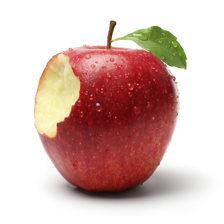

In [18]:
X_test[0]

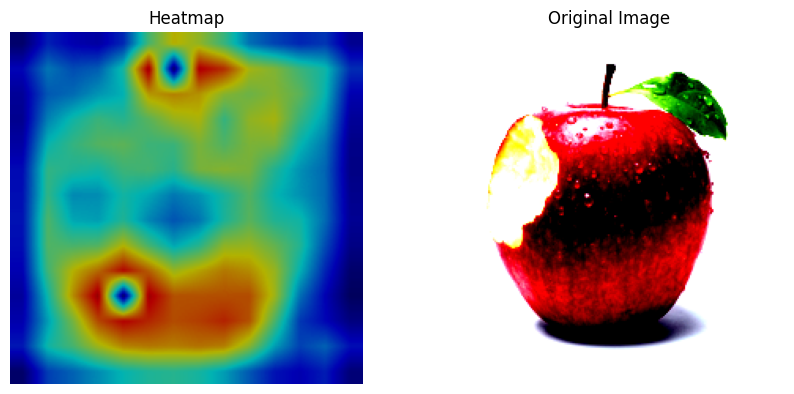

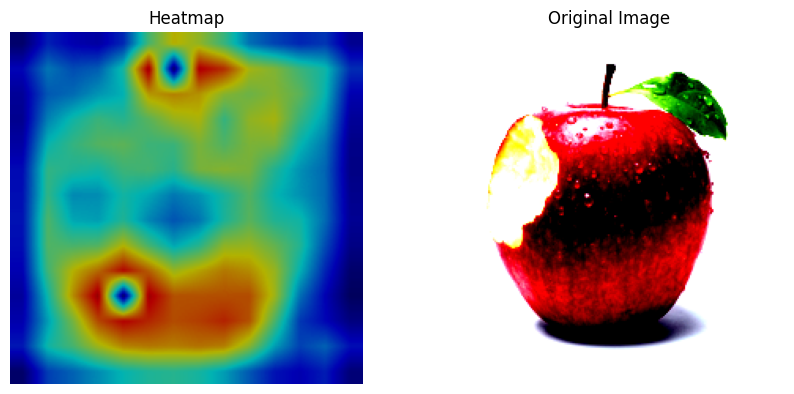

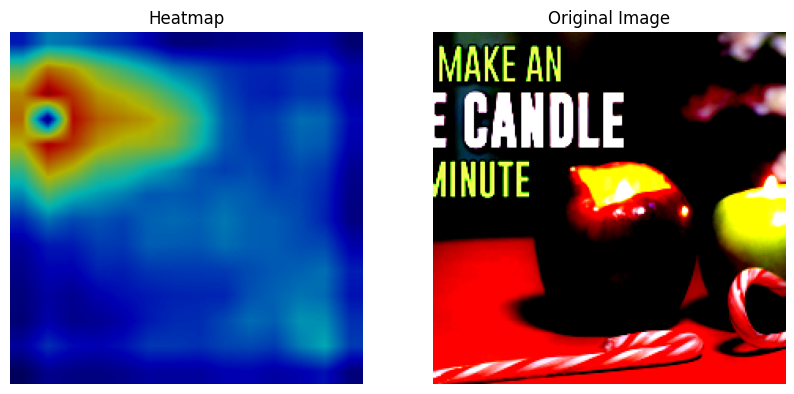

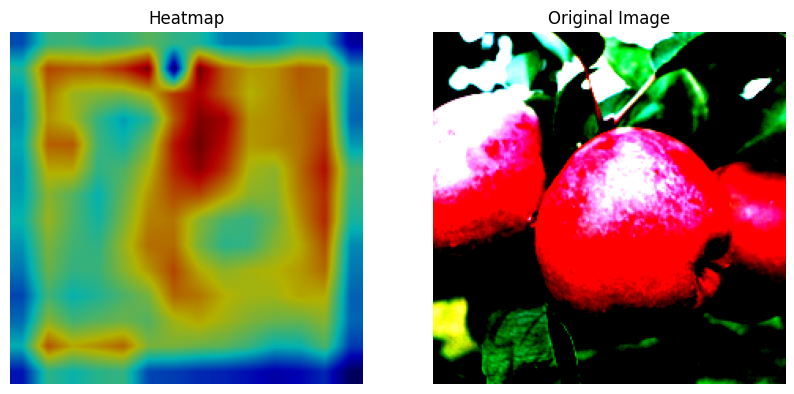

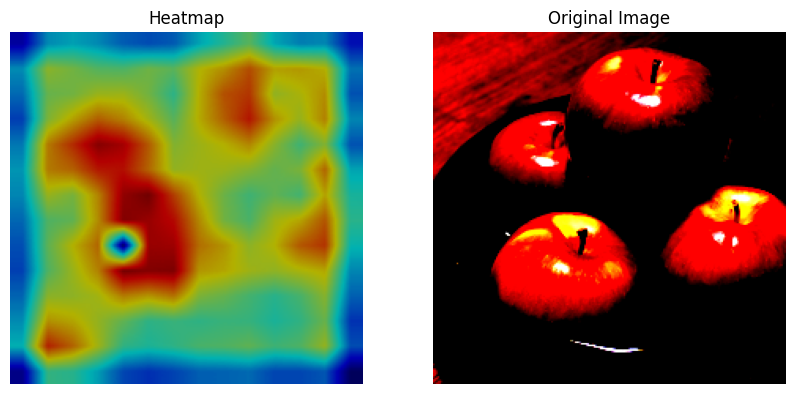

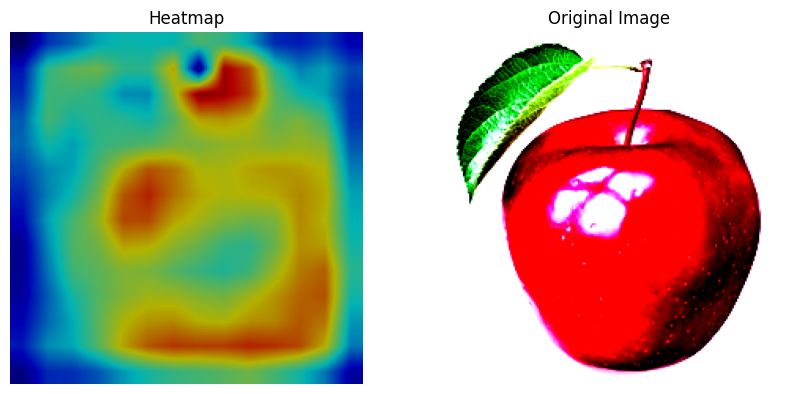

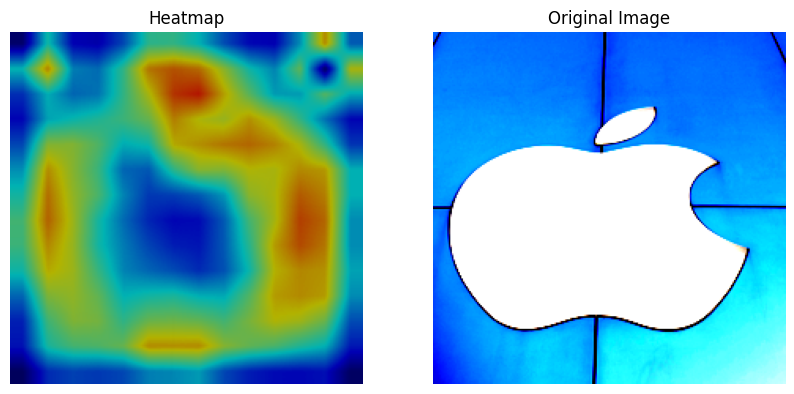

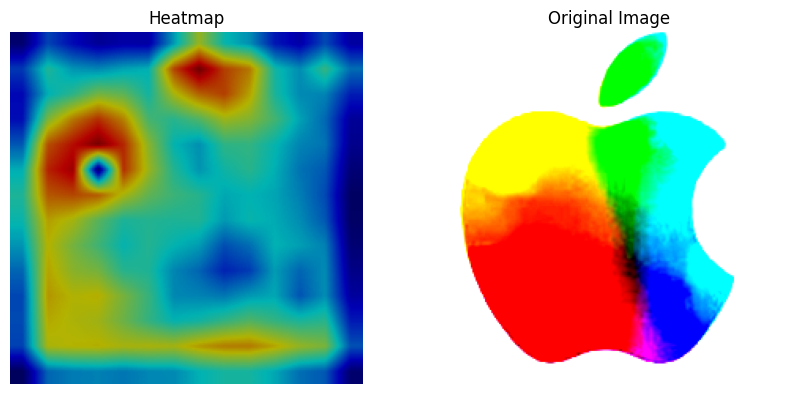

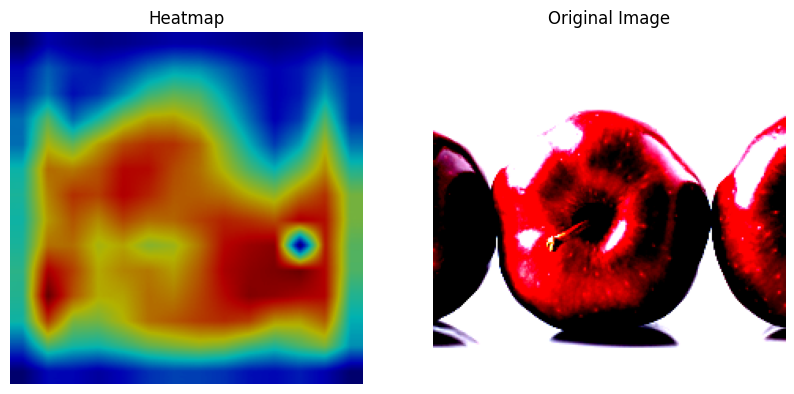

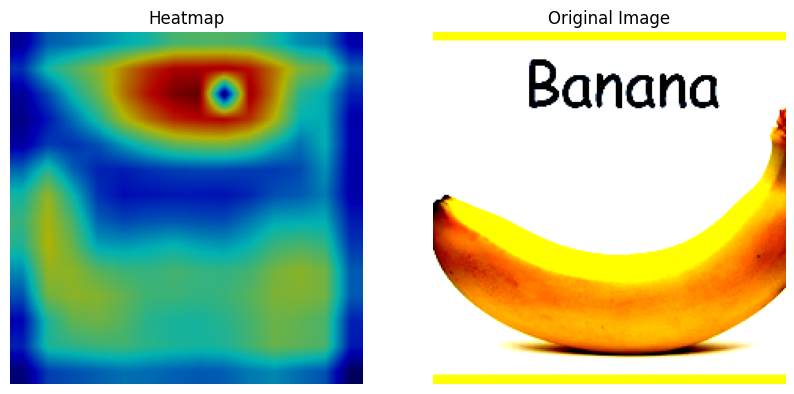

In [19]:
for i in range(0,10):
  example = Image.fromarray(X_test[i].astype(np.uint8)) # Convert numpy array to PIL Image
  example = transform(example) # Apply transformations
  example = example.unsqueeze(0) # Add batch dimension

  heatmap,pred = compute_heatmap(vgg_model,example)
  upsampled_map = upsampleHeatmap(heatmap, example)
  display_images(upsampled_map, example)

In [20]:
# Extends training data with additional set
X_train = np.concatenate([X_train, X_additional])
y_train = np.concatenate([y_train, y_additional])

In [21]:
print(f"additional + train = {len(X_train)}")

additional + train = 3245


In [22]:
# Convert training and testing image data into tensors
X_train = np.stack(X_train)
X_test = np.stack(X_test)

# Convert labels to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [23]:
# Store unscaled training and testing data without scaling for Mobilnetv3
X_train_not_scaled = X_train.copy()
X_test_not_scaled = X_test.copy()

In [24]:
# Scale data (images) for our model
X_train = X_train / 255
X_test = X_test / 255

In [25]:
# One hot encoding on labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [26]:
early = EarlyStopping(
    # Monitor accuracy on validation data
    monitor="val_accuracy",
    # Stop if there is no improvement of at least 0.3%
    min_delta=0.003,
    # Within the last 10 epochs
    patience=10,
    # If stopping, restore weights from the epoch with the highest validation accuracy
    restore_best_weights=True,
)

save = ModelCheckpoint(
    # Filepath to save the model
    filepath="best_model.keras",
    # Monitor accuracy on validation data
    monitor="val_accuracy",
    # Save only the best model based on the monitored metric
    save_best_only=True,
    # Save both the model architecture and weights in a single file
    save_weights_only=False,
    # Save after every epoch
    save_freq="epoch"
)

In [27]:
# Create a custom model - inspired by the VGG16 architecture
model = Sequential()

# Input layer must match the shape of X
model.add(Input(shape=X_train.shape[1:]))

# Convolutional block with pooling
model.add(Conv2D(16, (3, 3)))  # First convolutional layer
model.add(MaxPooling2D())  # First pooling layer
model.add(Conv2D(32, (3, 3)))  # Second convolutional layer
model.add(MaxPooling2D())  # Second pooling layer

# Flatten the feature maps into a vector
model.add(Flatten())

# Regularization to prevent overfitting (missing dropout or L2 regularization here)

# Output layer -> Multi-class single-label classification -> Softmax activation
model.add(Dense(36, activation="softmax"))

# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 36)                  │       3,359,268 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,364,356 (12.83 MB)

 Trainable params: 3,364,356 (12.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=32, callbacks=[early, save])

In [ ]:
plot_history(history)

In [ ]:
X_train.shape

In [ ]:
# Predikce na testovacích datech
y_pred = model.predict(X_test)

# Převést predikce na labely (indexy kategorií)
y_pred = np.argmax(y_pred, axis=1)

# Převést one-hot encoded y_test na labely (indexy kategorií)
y_test_labels = np.argmax(y_test, axis=1)

# Tisk classification reportu
print(classification_report(y_test_labels, y_pred, target_names=np.array(list(categories.values()))))


In [ ]:
# Predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions to labels (category indices)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test to labels (category indices)
y_test_labels = np.argmax(y_test, axis=1)

# Print the classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=np.array(list(categories.values()))))

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
# Redefine class labels from the encoding dictionary
class_labels = list(categories.values())

# Get the true labels and predicted labels
true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
pred_labels = model.predict(X_test)
pred_labels = np.argmax(pred_labels, axis=1) # Convert predictions to class indices

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Create a DataFrame for incorrect predictions
incorrect_predictions = pd.DataFrame({'index': np.where(true_labels != pred_labels)[0],
                                       'true_label': true_labels[np.where(true_labels != pred_labels)[0]],
                                       'predicted_label': pred_labels[np.where(true_labels != pred_labels)[0]]})

# Map label indices to label names using the encoding
incorrect_predictions['true_label_name'] = incorrect_predictions['true_label'].map(categories)
incorrect_predictions['predicted_label_name'] = incorrect_predictions['predicted_label'].map(categories)

# Print the DataFrame
incorrect_predictions

In [ ]:
plot_incorrect_predictions(incorrect_predictions, X_test)

In [ ]:
# Calculate grid dimensions
num_images = len(incorrect_predictions)
grid_cols = 4  # Number of columns in the grid
grid_rows = int(np.ceil(num_images / grid_cols))

# Create the grid of subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))  # Adjust figsize as needed

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through images and plot on grid
for i, index in enumerate(incorrect_predictions['index']):
    # Display the image on the subplot
    axes[i].imshow(X_val[index])

    # Set the title of the subplot
    title = f"True: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'true_label_name'].iloc[0]} \n Predicted: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'predicted_label_name'].iloc[0]}"
    axes[i].set_title(title)

    # Remove ticks and labels from the subplot
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Hide any unused subplots
for j in range(num_images, grid_cols * grid_rows):
    axes[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Load pre-trained model
vgg_model = torchvision.models.vgg16(pretrained=True)

# transformation for passing image into the network
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# selecting layers from the model to generate activations
image_to_heatmaps = nn.Sequential(*list(vgg_model.features[:-4]))

In [ ]:
# Activation map for incorrect predictions

for i, index in enumerate(incorrect_predictions['index']):
    # Display the image on the subplot
    example = X_val[index].unsqueeze(0)
    heatmap,pred = compute_heatmap(vgg_model,example)
    upsampled_map = upsampleHeatmap(heatmap, example)
    display_images(upsampled_map, example)

In [ ]:
plot_history(history)

In [ ]:
# načtení konvoluční featur extraction části MobilnetV3
base_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
)

In [ ]:
# první MobilnetV3 konvoluční část
x = base_model.output
# převod na vektor s redukcí dat pomocí poolingu
x = GlobalAveragePooling2D()(x)
# stejná klasifikační vrstva jako u vlastní neuronky
# regularizace
x = Dropout(0.2)(x)
# softmax vrstva podle úlohy
x = Dense(36, activation="silu")(x)

predictions = Dense(36, activation="softmax")(x)

# spojíme do kupy
model = Model(inputs=base_model.input, outputs=predictions)

# nepřetrénovávat MobilnetV3 vrstvy -> učíme pouze klasifikátor
for layer in base_model.layers:
    layer.trainable = False

# kompilace stejná jako u vlastní neuronky
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

In [ ]:
history = model.fit(X_train_not_scaled, y_train, epochs=1000, validation_data=(X_test_not_scaled, y_test), batch_size=32, callbacks=[early, save])

In [ ]:
plot_history(history)

In [ ]:
# Predikce na testovacích datech
y_pred = model.predict(X_test_not_scaled)

# Převést predikce na labely (indexy kategorií)
y_pred_labels = np.argmax(y_pred, axis=1)

# Převést one-hot encoded y_test na labely (indexy kategorií)
y_val_labels = np.argmax(y_test, axis=1)

# Tisk classification reportu
print(classification_report(y_val_labels, y_pred_labels, target_names=np.array(list(categories.values()))))

cm = confusion_matrix(y_val_labels, y_pred_labels) # Changed line
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
# Redefine class labels from the encoding dictionary
class_labels = list(categories.values())

# Assuming you already loaded your test data into X_test_not_scaled and y_test
# Get the true labels and predicted labels
true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
pred_labels = model.predict(X_test_not_scaled)
pred_labels = np.argmax(pred_labels, axis=1) # Convert predictions to class indices

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Create a DataFrame for incorrect predictions
incorrect_predictions = pd.DataFrame({'index': np.where(true_labels != pred_labels)[0],
                                       'true_label': true_labels[np.where(true_labels != pred_labels)[0]],
                                       'predicted_label': pred_labels[np.where(true_labels != pred_labels)[0]]})

# Map label indices to label names using the encoding
incorrect_predictions['true_label_name'] = incorrect_predictions['true_label'].map(categories)
incorrect_predictions['predicted_label_name'] = incorrect_predictions['predicted_label'].map(categories)

# Print the DataFrame
incorrect_predictions

In [ ]:
plot_incorrect_predictions(incorrect_predictions, X_test)

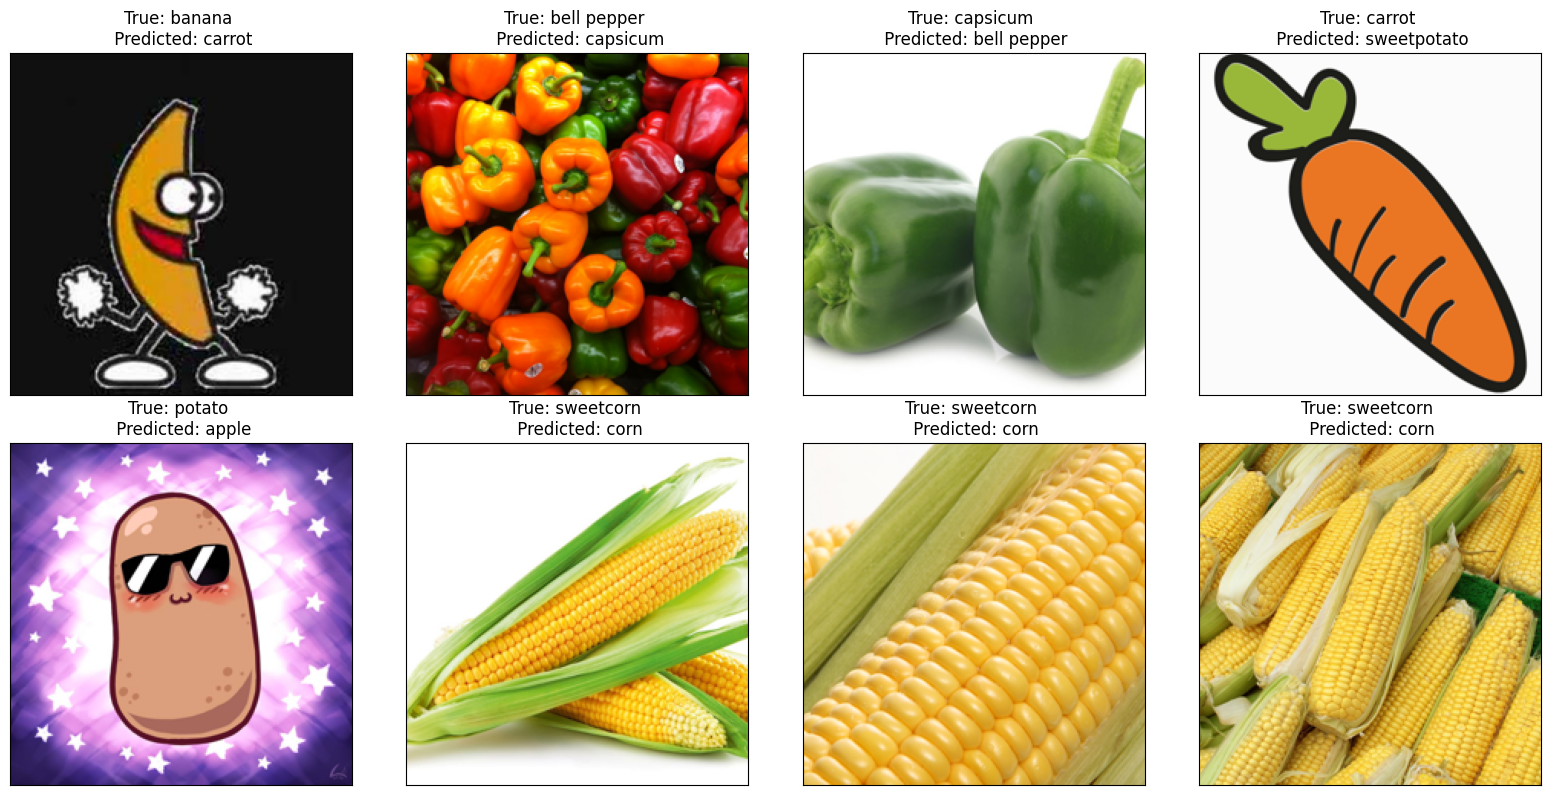

In [49]:
# Calculate grid dimensions
num_images = len(incorrect_predictions)
grid_cols = 4  # Number of columns in the grid
grid_rows = int(np.ceil(num_images / grid_cols))

# Create the grid of subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))  # Adjust figsize as needed

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through images and plot on grid
for i, index in enumerate(incorrect_predictions['index']):
    # Display the image on the subplot
    axes[i].imshow(X_test_not_scaled[index])

    # Set the title of the subplot
    title = f"True: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'true_label_name'].iloc[0]} \n Predicted: {incorrect_predictions.loc[incorrect_predictions['index'] == index, 'predicted_label_name'].iloc[0]}"
    axes[i].set_title(title)

    # Remove ticks and labels from the subplot
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Hide any unused subplots
for j in range(num_images, grid_cols * grid_rows):
    axes[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()